<h2>Photo-z validation metrics on Resampled Alhambra/Cosmos Data</h2>

This notebook shows how to load a .yaml /.p pickle file from all 100 of the resampled Alhambra/Cosmos validation files.

We then determine the error, from the spread of metric values from the 100 RS validation data, and also from the Cosmic Variance analysis.

*You will need to change the path and path_to_pickle_output_file  lines in the below cell*


In [1]:
import yaml
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import pickle
import bz2
import copy
import bh_photo_z_validation as pval
path = '/Users/hoyleb/Documents/python/modules/photoz-wg/validation/'

#these are the current best template and ML codes. Can you beat them!
path_to_pickle_output_file = path + 'LSS.COADD.ADAZ.p'

#leave this alone
path_to_cos_var_pickle_file = path + 'cosmic_variance_data/cosvariance_metrics.cos0alh.p.bz2'

if 'Y1' in path_to_pickle_output_file:
    science_sample = 'Y1'
    
if 'LSS' in path_to_pickle_output_file:
    science_sample = 'LSS'
    
if 'WL' in path_to_pickle_output_file:
    science_sample = 'WL'


In [2]:
class scaled_error():
    def __init__(self, const, scaling_type):
        self.const = const
        self.scaling = None
        if scaling_type == 'one_plus_z':
            self.scaling = self.one_plus_z 
        else:
            self.scaling = self.const_with_z
        
    def one_plus_z(self, z):
        return np.array((1 + z) * self.const)
    
    def const_with_z(self, z):
        return np.array(len(z) * [self.const])
    

In [3]:
almost_black = '#262626'
plt.rcParams['figure.figsize'] = (24, 8)
plt.rcParams.update({'font.size': 32, 
                     'axes.linewidth': 5,
                    'text.color': almost_black,
                    'xtick.major.size': 4,
                    'ytick.major.size': 4,
                    'legend.fancybox': True,
                    'figure.dpi': 300,
                    'legend.fontsize': 16,
                    'legend.framealpha': 0.8,
                    'legend.shadow': True,
                    'xtick.labelsize': 22,
                    'ytick.labelsize': 22})

<h3>Set up the requirements and plotting </h3>

Define what plotting symbols to use, and also Y5 requirements


In [4]:

#which bining column should we choose?
bin_column = 'MEAN_Z'

#requirements from science handbook
# http://des-docdb.fnal.gov:8080/cgi-bin/RetrieveFile?docid=20&filename=sciReq-9.86.pdf&version=32
# http://des-docdb.fnal.gov:8080/cgi-bin/ShowDocument?docid=1719
requirements = {'sigma_68':{'value': 0.12, 'error': scaled_error(0.003, 'const')},
                'wl_metric': {'value': 0.02, 'error': scaled_error(0.003, 'const')},
                'outFrac_2sigma68': { 'value': 0.1 , 'error': scaled_error(0.001, 'const') },
                'outFrac_3sigma68': {'value': 0.015, 'error': scaled_error(0.0015, 'const') },
                'median': {'value': 0, 'error': scaled_error(0.001, 'one_plus_z') },
                }

#plotting ranges
plt_range = {'sigma_68': [0, 0.5],
            'wl_metric': [0, 0.1],
            'outFrac_2sigma68': [0, 0.3],
            'outFrac_3sigma68': [0, 0.3],
             'median' : [-0.1, 0.1]
            }

metric_latex = {
    'sigma_68' :'$\sigma_{68}(z_{true} - z_{pred})$',
    'sigma_68_1pz' :'$\sigma_{68}((z_{true} - z_{pred})/(1 + z_{true}))$',
    'wl_metric': '$|<z_{true}> - <z^{MC}_{pred}>|$',
    'outFrac_2sigma68': '$f(>2*\sigma_{68})$',
    'outFrac_3sigma68': '$f(>3*\sigma_{68})$',
    'outFrac_2sigma68_1pz': '$f(>2*\sigma_{68}/(1+z))$',
    'outFrac_3sigma68_1pz': '$f(>3*\sigma_{68}/(1+z))$',
    'median' : '$\mu(z_{true} - z_{pred})$',
    'median_1pz' : '$\mu(z_{true} - z_{pred})/(1 + z_{true})$',
    'delta_sigma_crit': '$\Delta \Sigma_{C}'
}


<h3>Metrics of interest</h3>

Let us decide which metrics we want to measure. Edit this list with metrics that we measured from the validation script. Look at the structure of the validation .yaml file to understand this indexing.

In [14]:
if science_sample == 'WL':
    weight = ['IN_WL_SAMPLE', 'WL_WEIGHT'] # list of applicable weights
    
    #'metric_name': [WHICH_Z_COLUMN, METRIC NAME]
    metrics = {
        'median': ['MEAN_Z', 'vlfn.median'],    
        'sigma_68': ['MEAN_Z', 'vlfn.sigma_68'],
        'outFrac_2sigma68':['MEAN_Z','vlfn.outFrac_2sigma68'],  
        'wl_metric': ['Z_MC', 'vlfn.wl_metric'],
        #'delta_sigma_crit': ['Z_MC', 'vlfn.delta_sigma_crit']      
           }

    #what is the WL binning structure.
    bins = [0, 0.1, 0.2, 0.43, 0.63, 0.9, 1.3]

    
if science_sample == 'LSS':
    weight = ['IN_LSS_SAMPLE'] # list of applicable weights
    
    #lss has other different requirements
    requirements = {'sigma_68':{'value': scaled_error(0.03, 'one_plus_z') , 'error': 0.03},
                'outFrac_2sigma68': { 'value': scaled_error(0.1, 'const') , 'error': scaled_error(0.001, 'const') },
                'outFrac_3sigma68': {'value': scaled_error(0.015, 'const'), 'error': scaled_error(0.0015, 'const') },
                'median': {'value': 0, 'error': scaled_error(0.001, 'one_plus_z') },
             }
    #'metric_name': [WHICH_Z_COLUMN, METRIC NAME]
    metrics = {
        'median': ['MEAN_Z', 'vlfn.median'],
        'median_1pz': ['MEAN_Z', 'vlfn.median_1pz'],           
        'sigma_68': ['MEAN_Z', 'vlfn.sigma_68'],
        'sigma_68_1pz': ['MEAN_Z','vlfn.sigma_68_1pz'], 
        'outFrac_2sigma68':['MEAN_Z','vlfn.outFrac_2sigma68'], 
        'outFrac_3sigma68':['MEAN_Z','vlfn.outFrac_3sigma68']     
       }
    
    #plotting ranges
    plt_range = {
        'sigma_68': [0, 0.2],
        'sigma_68_1pz': [0, 0.2],
        'outFrac_2sigma68': [0, 0.3],
        'outFrac_3sigma68': [0, 0.3],
        'median' : [-0.1, 0.1],
        'median_1pz': [-0.1, 0.1]
        
            }
    #what is the WL binning structure.
    bins = [0.6, 0.7, 0.8, 0.9, 1.0]

bns_str = ','.join(str(bi) for bi in bins).replace(' ','')


<h3>Load results files</h3>

Now let's load the .p [pickle] file output from the validation pipeline, and also the cosmic variance results we calculated elsewhere [Ask Youngsoo/Ben/Markus for details].


In [6]:
if path_to_pickle_output_file[-4:] == '.bz2':
    res = pickle.load(bz2.BZ2File(path_to_pickle_output_file, 'r'))
else:
    res = pickle.load(open(path_to_pickle_output_file, 'r'))

original_test_config = copy.copy(res['test_config'])
del res['test_config']

cosvar = pickle.load(bz2.BZ2File(path_to_cos_var_pickle_file, 'r'))

test_dict = cosvar[0][bns_str]['test']

print (test_dict)

{'extra_params': {'vlfn.delta_sigma_crit': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]}, 'truths': 'Z', 'metrics': {'Z_MC': ['vlfn.wl_metric', 'vlfn.delta_sigma_crit'], 'MEAN_Z': ['vlfn.median', 'vlfn.median_1pz', 'vlfn.sigma_68_1pz', 'vlfn.sigma_68', 'vlfn.outFrac_2sigma68_1pz', 'vlfn.outFrac_3sigma68_1pz', 'vlfn.outFrac_2sigma68', 'vlfn.outFrac_3sigma68']}, 'weights': ['IN_WL_SAMPLE', 'IN_LSS_SAMPLE'], 'error_function': None, 'bins': {'MEAN_Z': [0.6, 0.7, 0.8, 0.9, 1.0]}}


In [7]:
files = res.keys()
def get_val(dct, ky):
    return dct[ky]
label = path_to_pickle_output_file.split('/')[-1].replace('.p', '')
print (label)

LSS.COADD.ADAZ


In [8]:
#get the error component from the 200 SLR corrections applied to the validation files
    
m_res = {} #temporary value storage
metric_res = {} #this holds the median metric value, and std from the RS samples. Also the binned results

for m in metrics.keys(): 
    met_kys = metrics[m]
    m_res[m] = {}
    metric_res[m] = {}

    for wgt in weight:
        m_res[m][wgt] = {'VALUES': [], 'BINS_ID': {}}
        metric_res[m][wgt] = {'VALUES': [], 'BINS_ID': {}}
            
    for f in files:
        for j, ky in enumerate(met_kys):
            if j ==0:
                dct_ = get_val(res[f], ky)
            else:
                dct_ = get_val(dct_, ky)
        #now get the results as weighte by each
        for wgt in weight:
            dct = dct_[wgt]
            #get the unbinned value
            m_res[m][wgt]['VALUES'].append(dct['value'])
        
            #Each resampled file can have a different <z> per bin, so find the 
            #index of the original bins [in test.yaml] that corresponds to this redshift
            for j, zbn in enumerate(dct['bins'][bin_column]['bin_center']):
                if np.isfinite(zbn) and zbn > 0:
                    indj = np.where((zbn < bins[1:]) * (zbn >= bins[0:-1]))[0][0]
                    if indj not in m_res[m][wgt]['BINS_ID']:
                        m_res[m][wgt]['BINS_ID'][indj] = {}
                        m_res[m][wgt]['BINS_ID'][indj]['BIN_CENTER'] = []
                        m_res[m][wgt]['BINS_ID'][indj]['VALUE'] = []

                    m_res[m][wgt]['BINS_ID'][indj]['BIN_CENTER'].append(zbn)
                    m_res[m][wgt]['BINS_ID'][indj]['VALUE'].append(dct['bins'][bin_column]['value'][j])


            #get the median value and the error component from the 68% [standard deviation] of the resampled data.
            metric_res[m][wgt]['SIGMA'] = pval.sigma_68(m_res[m][wgt]['VALUES'])
            metric_res[m][wgt]['VALUES'] = np.median(m_res[m][wgt]['VALUES']) 

            for j, indj in enumerate(m_res[m][wgt]['BINS_ID'].keys()):

                    metric_res[m][wgt]['BINS_ID'][indj] = {}
                    metric_res[m][wgt]['BINS_ID'][indj]['BIN_CENTER'] = np.median(m_res[m][wgt]['BINS_ID'][indj]['BIN_CENTER'])

                    #overwrite the lists to save some memory space
                    metric_res[m][wgt]['BINS_ID'][indj]['SIGMA'] =  pval.sigma_68(m_res[m][wgt]['BINS_ID'][indj]['VALUE'])
                    metric_res[m][wgt]['BINS_ID'][indj]['VALUE'] = np.median(m_res[m][wgt]['BINS_ID'][indj]['VALUE'])


<h3>Next add in CosmicVariance error component</h3>

We repeat the above, and additionally calculate the error on each metric from cosmic variance. and from validating on high quality photo-z instead of spec-z

In [9]:
#this will hold the median metric values, RS errors, AND CosVar Errors
sample_var_cosz = {}
sample_var_truez = {}

for m in metrics.keys(): 
    met_kys = metrics[m]
    
    sample_var_truez[m] = {}
    for wgt in weight:
        sample_var_truez[m][wgt] = {'VALUES': [], 'BINS_ID': {}}
        
    for wgt in weight:
        tst_weight = wgt
        if wgt == 'WL_WEIGHT':
            tst_weight = 'IN_WL_SAMPLE'

        #we only care about the bin numbers that we have measured data in
        for j, indj in enumerate(metric_res[m][wgt]['BINS_ID']):
            sample_var_truez[m][wgt]['BINS_ID'][indj] = {}
            sample_var_truez[m][wgt]['BINS_ID'][indj]['VALUE'] = []
            sample_var_truez[m][wgt]['BINS_ID'][indj]['BIN_CENTER'] = []


        #loop over all simulated files.
        for f in cosvar:
            for j, ky in enumerate(met_kys):
                if j ==0:
                    z_dct = get_val(f[bns_str]['Z'], ky)
                else:
                    z_dct = get_val(z_dct, ky)
            
            z_dct = z_dct[tst_weight]
            #get the value for all unbinned data        
            sample_var_truez[m][wgt]['VALUES'].append(z_dct['value'])

            #determine which bin we are referring to

            for j, zbn in enumerate(z_dct['bins'][bin_column]['bin_center']):  
                indj = np.where((zbn < bins[1:]) * (zbn >= bins[0:-1]))[0][0]
                if indj in sample_var_truez[m][wgt]['BINS_ID'].keys():
                    sample_var_truez[m][wgt]['BINS_ID'][indj]['BIN_CENTER'].append(z_dct['bins'][bin_column]['bin_center'][j])
                    sample_var_truez[m][wgt]['BINS_ID'][indj]['VALUE'].append(z_dct['bins'][bin_column]['value'][j])


        #calculate the 68% spread of these metric values
        sample_var_truez[m][wgt]['SIGMA']  = pval.sigma_68(sample_var_truez[m][wgt]['VALUES'])
        sample_var_truez[m][wgt]['VALUES']  = np.median(sample_var_truez[m][wgt]['VALUES'])

        #for each bin number, calculate the bin center, sigmas and mean value
        for j, indj in enumerate(sample_var_truez[m][wgt]['BINS_ID']):
            sample_var_truez[m][wgt]['BINS_ID'][indj]['BIN_CENTER'] = np.median(
                sample_var_truez[m][wgt]['BINS_ID'][indj]['BIN_CENTER']
            )
            sample_var_truez[m][wgt]['BINS_ID'][indj]['SIGMA'] = pval.sigma_68(
                sample_var_truez[m][wgt]['BINS_ID'][indj]['VALUE']
                )
            sample_var_truez[m][wgt]['BINS_ID'][indj]['VALUE'] = np.median(
                sample_var_truez[m][wgt]['BINS_ID'][indj]['VALUE']
            )
        

<h3>Plot both error components</h3>

Let's add the cosmic variance error in quadrature to the ReSample error, and plot the results for each metric, as a function of the tomographic bins.

---------------------------------
weight: IN_LSS_SAMPLE
metric: | sigma_68_1pz
Mean & Combined Err & SampVar Err & CosVar Err & \\
0.3056 \pm 0.0168  ( 1.5e-03 \pm 1.7e-02) \\ 
---------------------------------
weight: IN_LSS_SAMPLE
metric: | median_1pz
Mean & Combined Err & SampVar Err & CosVar Err & \\
0.0258 \pm 0.0062  ( 1.6e-03 \pm 6.0e-03) \\ 


AttributeError: scaled_error instance has no attribute '__float__'

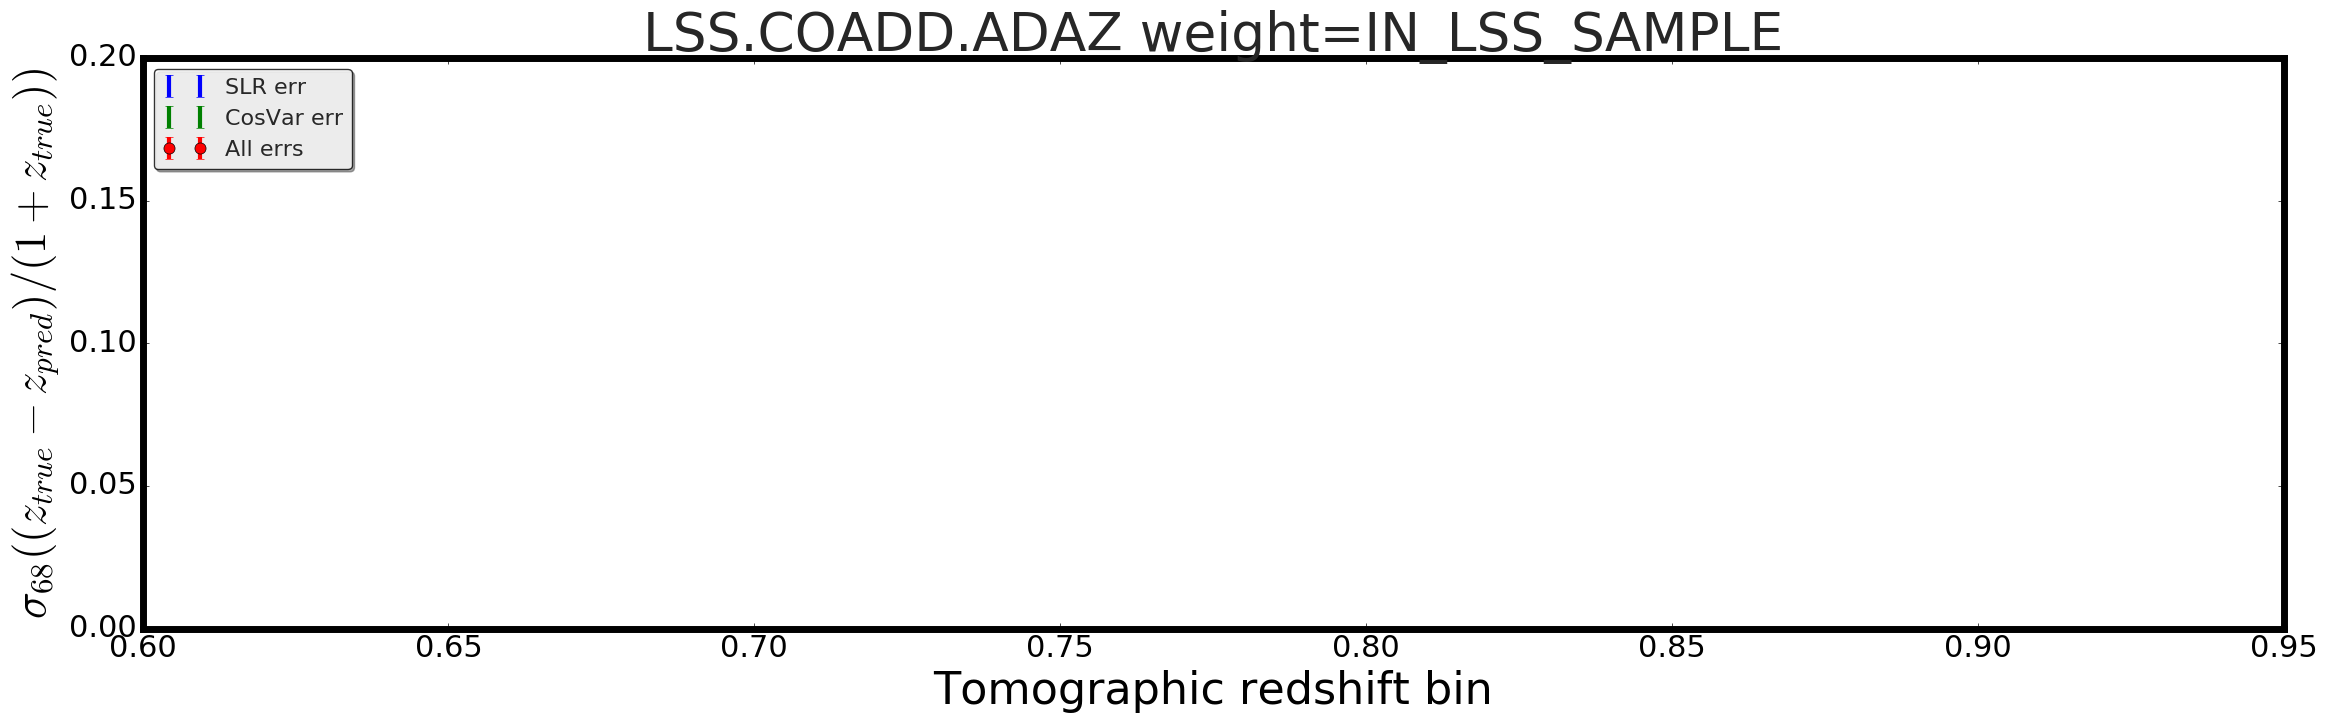

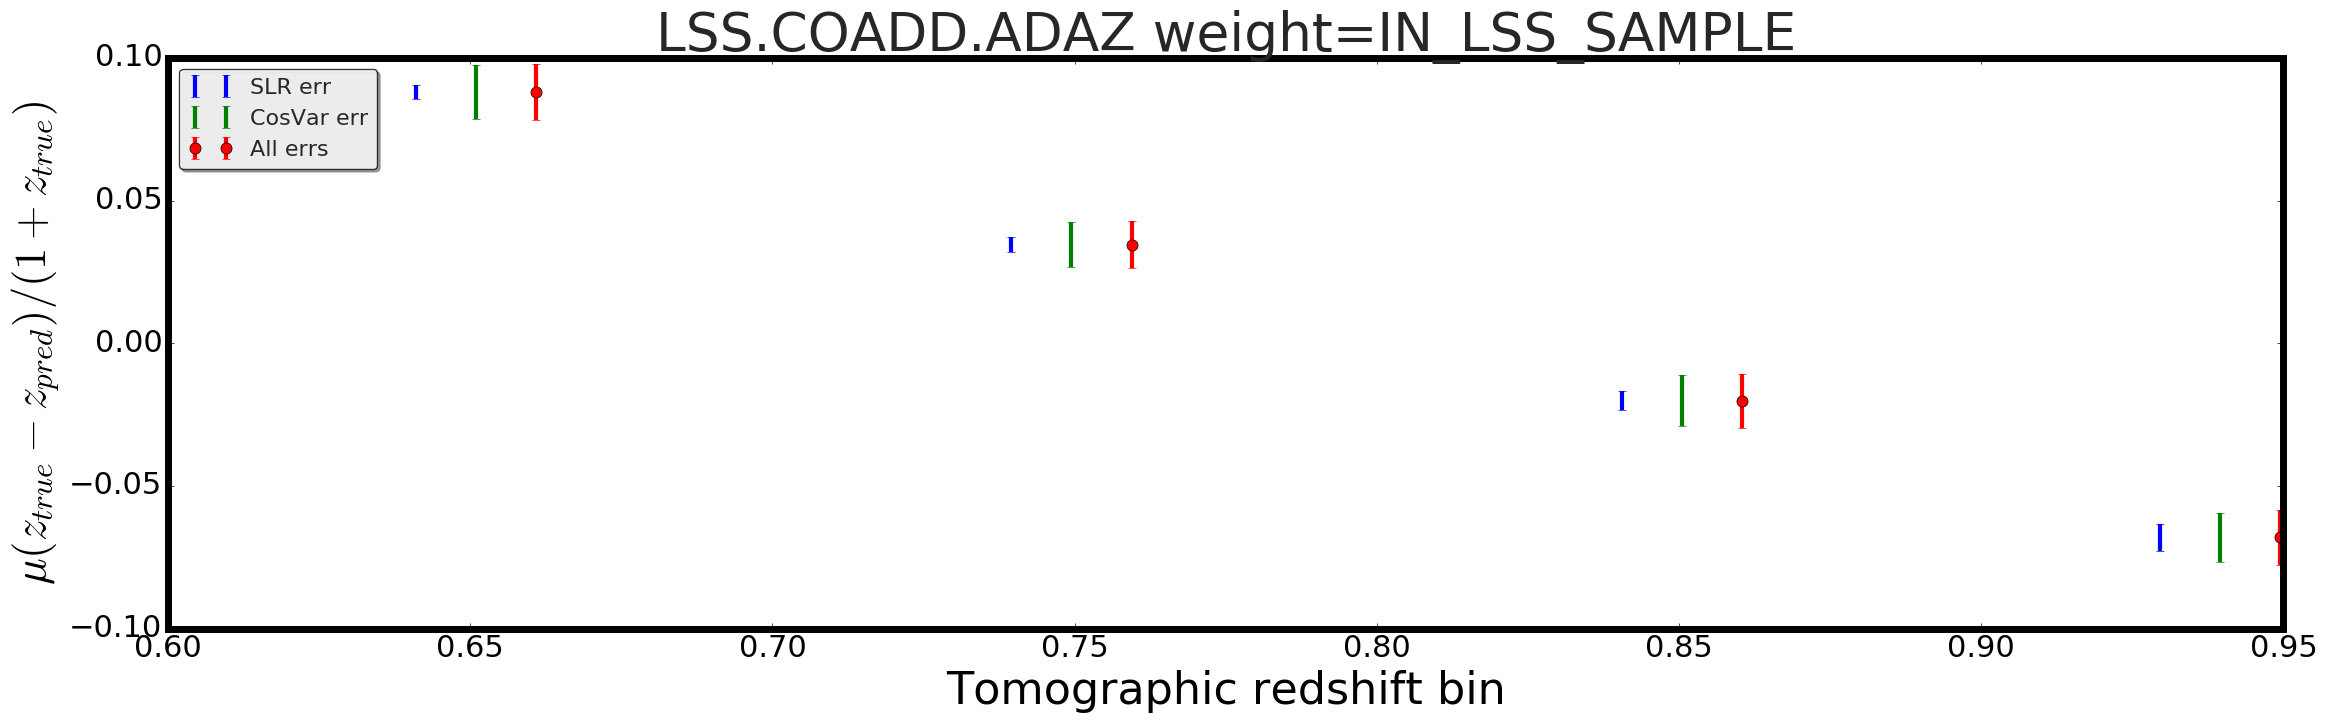

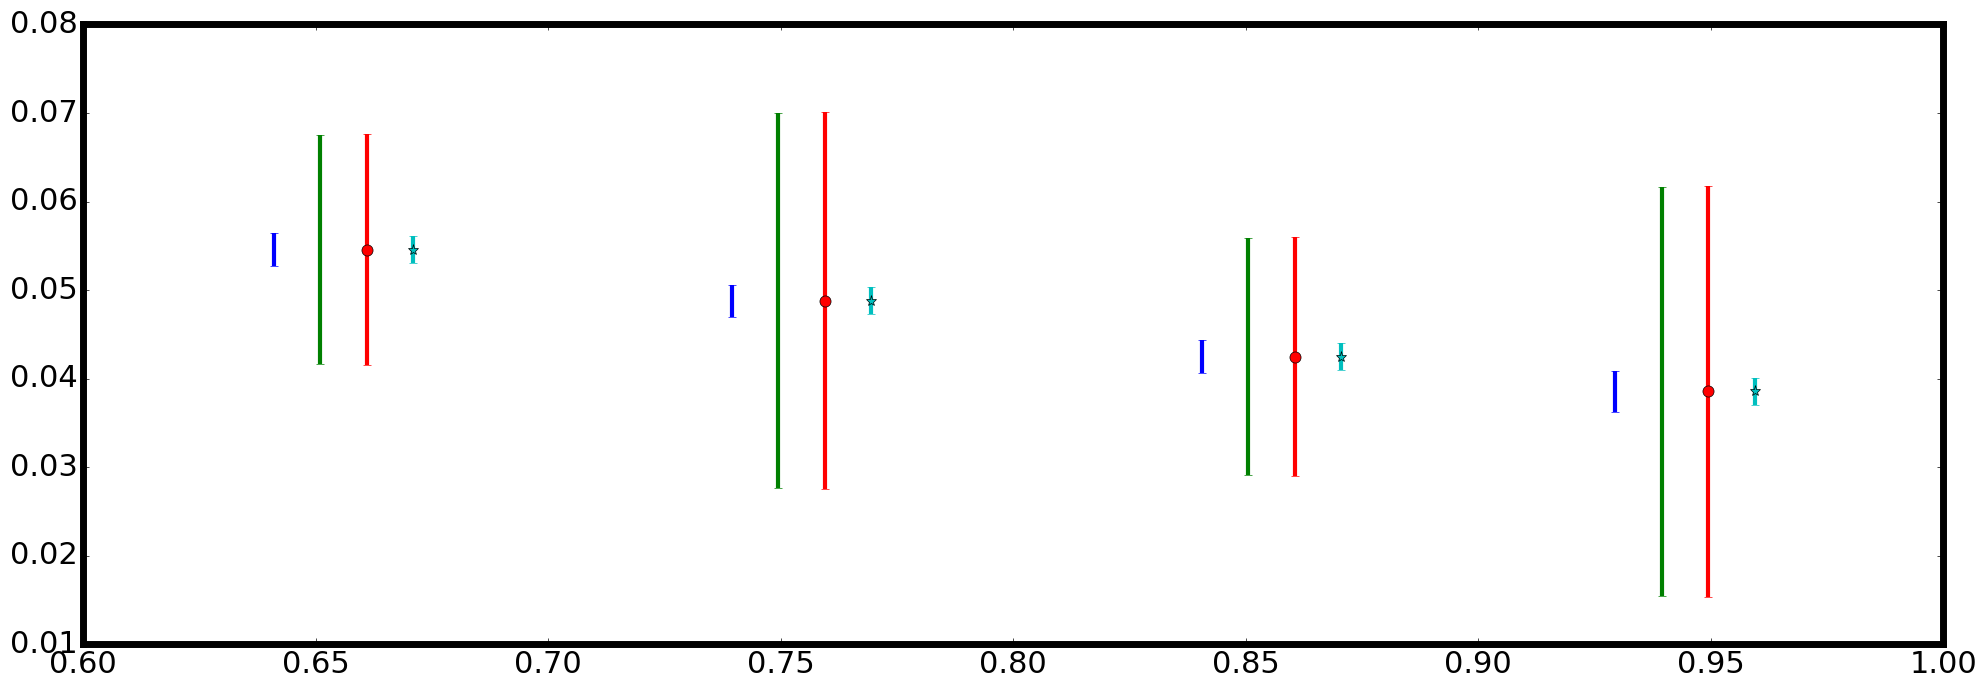

In [15]:
Ms = 8
lw = 3

for m in metric_res:
    
    for wght in metric_res[m]:
        f= plt.figure()
        indjs = metric_res[m][wght]['BINS_ID'].keys()
        z = np.array([metric_res[m][wght]['BINS_ID'][indj]['BIN_CENTER'] for indj in indjs])
        errRS = np.array([metric_res[m][wght]['BINS_ID'][indj]['SIGMA'] for indj in indjs]) #err from ReSample
        errCV = np.array([sample_var_truez[m][wght]['BINS_ID'][indj]['SIGMA'] for indj in indjs]) #err from CosVar to photo-z
        
        
        err = np.sqrt(errRS**2 + errCV**2 ) #add in quadrature
        y = np.array([metric_res[m][wght]['BINS_ID'][indj]['VALUE'] for indj in indjs])
        
        plt.errorbar(np.array(z)-0.01, y, yerr=errRS, fmt=',', markersize=str(Ms), elinewidth=lw, label='SLR err')
        plt.errorbar(np.array(z), y, yerr=errCV , fmt=',',markersize=str(Ms), elinewidth=lw, label='CosVar err')
        plt.errorbar(np.array(z)+0.01, y, yerr=err, fmt='o',markersize=str(Ms), elinewidth=lw, label='All errs')

        #get requirements:
        if m in requirements:
            err_req = requirements[m]['error'].scaling(np.array(z))
            plt.errorbar(np.array(z)+0.02, y, yerr=err_req, fmt='*',markersize=str(Ms), elinewidth=lw, label='Error req.')

            val_req = [requirements[m]['value']]*len(z)
            plt.plot(np.array(np.sort(z)), val_req,'--', linewidth=3,label='Value req.')

        plt.xlabel('Tomographic redshift bin')
        plt.title('{:} weight={:}'.format(label, wght))
        plt.ylim(plt_range[m])
        plt.ylabel(metric_latex[m])
        plt.legend(loc=2)
        plt.tight_layout()
        plt.savefig(label + wght + m + '.pdf')
        print ("---------------------------------")
        print ('weight: {:}'.format(wght))
        print ('metric: | {:}'.format(m))
        mean = metric_res[m][wght]['VALUES']
        rsErr = metric_res[m][wght]['SIGMA']
        cosVarErr = sample_var_truez[m][wght]['SIGMA']
        err = np.sqrt(rsErr**2 + cosVarErr**2)
        print ('Mean & Combined Err & SampVar Err & CosVar Err & \\\\')
        print ('{:0.4f} \pm {:0.4f}  ( {:0.1e} \pm {:0.1e}) \\\\ '.format(mean, err, rsErr, cosVarErr))

<h3>You're done!</h3>

Please share the results with the redshift wg.

<h3>Generating the sample (cosmic) variance</h3>

This code snippet loads in a heap of validation script outputs, measured on each patch in a simulation, and stores the resulting list in the cosmic variance file in the validation directory.

In [ ]:
files = glob.glob('/Users/hoyleb/DATA/DES/PHOTOZ/COSMIC_VAR/cos_0alh*.p')
files = [i for i in files if 'Alh' not in i and 'e5' not in i]
res = []
for fil in files:
    r = pickle.load(open(fil, 'r'))
    res.append(r)
print len(res)
pickle.dump(res, bz2.BZ2File(path + '/cosmic_variance_data/cosvariance_metrics.cos0alh.p.bz2', 'w'))

files = glob.glob('/Users/hoyleb/DATA/DES/PHOTOZ/COSMIC_VAR/cos_1alh*.p')
res = []
for fil in files:
    r = pickle.load(open(fil, 'r'))
    res.append(r)
print len(res)
pickle.dump(res, bz2.BZ2File(path + '/cosmic_variance_data/cosvariance_metrics.cos1alh.p.bz2', 'w'))

files = glob.glob('/Users/hoyleb/DATA/DES/PHOTOZ/COSMIC_VAR/cos_2alh*.p')
files = [i for i in files if 'e5' not in i]
res = []
for fil in files:
    r = pickle.load(open(fil, 'r'))
    res.append(r)
print len(res)
pickle.dump(res, bz2.BZ2File(path + '/cosmic_variance_data/cosvariance_metrics.cos2alh.p.bz2', 'w'))


In [ ]:
import copy
cos_noalh = copy.deepcopy(cos_vv)

In [ ]:
mm = ['wl_metric', 'sigma_68', 'median', 'outFrac_2sigma68']

for m in mm:
    plt.plot(z, (cos_vv[m] - cos_noalh[m])*100/cos_vv[m], label=m)

plt.legend()
plt.xlabel('Tomographic bin')
plt.ylabel('CosVar uncertainty Reduction with Y3Alh')
f = plt.figure()
cnt=0
col = ['red', 'blue', 'green', 'yellow']
for m in mm:
    plt.plot(z, cos_noalh[m] , '--',color=col[cnt], label='cos' + m)
    plt.plot(z, cos_vv[m] ,color=col[cnt],  label='cos2alh' + m, linewidth=2 )
    
        #get requirements:
    if m in requirements:
        err_req = requirements[m]['error'].scaling(np.array(z))
        plt.plot(np.array(z), err_req,'o-', color=col[cnt], label='Error req.', linewidth=1 )
    cnt += 1    
plt.legend()
plt.xlabel('Tomographic bin')
plt.ylabel('CosVar uncertainty [Cos field]')   


<h3>Validation on 1x cosmos-like simulation</h3>

In [ ]:
res = pickle.load(bz2.BZ2File(path + '/cosmic_variance_data/cosvariance_metrics.cos0alh.p.bz2', 'r'))

In [ ]:
labels = ['WL_bins1', 'WL_bins2', 'LSS']
ssample = ['IN_WL_SAMPLE', 'IN_WL_SAMPLE', 'IN_LSS_SAMPLE']
for ii, i in enumerate(res[0]):
    print i
    r_ = res[0][i]['Z']['Z_MC']['vlfn.wl_metric'][ssample[ii]]['bins']['MEAN_Z']
    error = np.array([j[i]['Z']['Z_MC']['vlfn.wl_metric'][ssample[ii]]['bins']['MEAN_Z']['value'] for j in res])
    err = np.std(error, axis=0)
    plt.errorbar(r_['bin_center'], r_['value'], yerr=err, fmt='o', alpha=0.9, label=labels[ii])
    if ii ==1:
        print ', '.join(['{:0.3}'.format(k) for k in r_['bin_center']])
        print ', '.join(['{:0.3}'.format(k) for k in r_['value']])
        print ', '.join(['{:0.3}'.format(k) for k in err])
plt.legend()
plt.xlabel('Redshift')
plt.ylabel('|<z_true>-<z_mc>|')

In [ ]:
Bin, Zmc , truth
1, 0.35, 0.29
2, 0.52, 0.44
3, 0.75, 0.70
4, 1.01, 0.94


In [ ]:
print 'bin1 true delta_z', 0.35 - 0.29,'valid:', 0.0761, '+-',0.0105
print 'bin2 true delta_z',0.52 - 0.44, 'valid:',0.102, '+-',0.013
print 'bin3 true delta_z',0.75- 0.70,  'valid:',0.0531, '+-', 0.0135
print 'bin4 true delta_z',1.01 - 0.94, 'valid:',0.0509,'+-', 0.0212

In [ ]:
(0.08 - 0.102)/0.013, (0.06 -0.07610)/ 0.0105 

In [ ]:
t =''
for z_l in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    t += ',WEIGHT_ZLENS_{:}'.format(z_l)
print t